 # <center>Missing Data

Regrettably, real-world data can be far more challenging to work with than the meticulously curated datasets you have utilised thus far. Numerous inconsistencies and issues can arise that must be addressed before any meaningful analysis can take place. Today, we will examine the topics of missing data—how to identify and manage it—as well as the presence of outliers. We will explore methods for recognising these issues and effective strategies for addressing them.

## Practicalities

How to find and manipulate missing values in a numpy array. Note the library Pandas has functionality to work directly with missing values.

Missing values will be represented by <code>np.nan</code>, which is numpy's representation of not a number.

In [1]:
import numpy as np
testData = np.array([[1,np.nan,np.nan],[4,5,6],[7,8,9],[10,11,12]])
testData

array([[ 1., nan, nan],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.],
       [10., 11., 12.]])

In [2]:
print(np.isnan(testData))  # which elements are missing.

[[False  True  True]
 [False False False]
 [False False False]
 [False False False]]


In [3]:
# Which rows contain at least one missing value. (Use .all() if you want rows that are all missing).
print(np.isnan(testData).any(axis = 1, keepdims = True))
testData.all()

[[ True]
 [False]
 [False]
 [False]]


np.True_

In [4]:
# Which columns contain at least one missing value.
print(np.isnan(testData).any(axis = 0))

[False  True  True]


In [5]:
# Count the number of missing values along each row.
np.sum(np.isnan(testData),axis = 1)

array([2, 0, 0, 0])

In [6]:
# Count the number of missing values along each column.
np.sum(np.isnan(testData),axis = 0)

array([0, 1, 1])

In [7]:
# Total proportion of missing values for each column
np.sum(np.isnan(testData),axis =0)/testData.shape[0]

array([0.  , 0.25, 0.25])

In [8]:
# Remove columns with any missing data
testData[:,~np.isnan(testData).any(axis = 0)] # note the ~.

array([[ 1.],
       [ 4.],
       [ 7.],
       [10.]])

In [9]:
# Remove rows with any missing data.
testData[~np.isnan(testData).any(axis = 1),:]

array([[ 4.,  5.,  6.],
       [ 7.,  8.,  9.],
       [10., 11., 12.]])

### A Simple Dataset

In the first instance we shall use data drawn from a two-dimensional Gaussian distribution:

$p(X) = \mathcal{N}(X|\mu, \Sigma)$, where
$\mu =\begin{bmatrix} 5\\ 5\\ \end{bmatrix}$ and
$ \Sigma =  \begin{bmatrix} 1 & 0\\ 0 & 1\\ \end{bmatrix}$


In [10]:
import numpy as np
num_samples = 1000
mn = np.array([5,5])
cov = np.array([[1,0],
               [0,1]])
x,y = np.random.multivariate_normal(mn,cov, num_samples).T

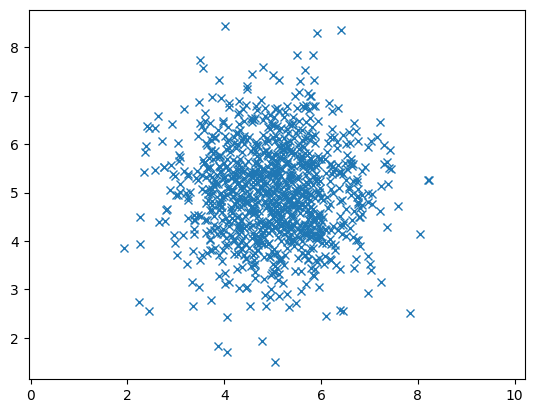

In [11]:
import matplotlib.pyplot as plt
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [12]:
np.mean((x,y), axis =1)

array([4.99298952, 4.99263408])

In [13]:
np.cov((x,y))

array([[ 1.01871326, -0.02513293],
       [-0.02513293,  1.01341179]])

Missing data can arise for various reasons, but in some cases, a seemingly absent value may not actually indicate a missing data issue. For instance, consider a shop that records its daily income each day except on Wednesdays when it is closed. In this scenario, the income for Wednesdays is not missing; rather, it simply reflects the shop's closure.

We will explore the statistical mechanisms that contribute to missingness, which can be categorised into three types: *Missing Completely at Random*, *Missing at Random*, and *Not Missing at Random*.

## Missing Completely at Random (MCAR)

Data that are missing are selected uniformly at random by row/column location and have nothing to do with the values of the data itself. We can generate MCAR missing data as follows:

In [14]:
# Emulating MCAR, we simply select a row uniformly at random and replace with np.nan.
# generate 10 values between 0 and n-1.
n = num_samples
rows = np.random.randint(0,n,10)
rows

# This can lead to having the same row being selected more than once,so this method will create at most 10 missing values

# Using a permutation means all values will be unique.
rows = np.random.permutation(n)[:10]

In [15]:
# Here we are converting X into a column that has MCAR missingness.
x[rows]=np.nan
np.mean((x,y), axis = 1)

array([       nan, 4.99263408])

In [16]:
np.nanmean((x,y), axis = 1) # ignore np.nan values.
# Unfortunately there is no equivalent for covariance.

array([4.99419821, 4.99263408])

In [17]:
# We can use a masked array,np.ma. Masked arrays are a sub-class of numpy arrays that can handle missing data.
masked = np.ma.masked_invalid((x,y)) # create masked array with missing data.
# masked array class has functionality for calculating mean/covariance.
np.ma.cov(masked)

masked_array(
  data=[[1.022149103705051, -0.026458727987076883],
        [-0.026458727987076883, 1.0134117900927615]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

In [18]:
np.ma.mean(masked, axis =1).data # ignoring the additional information returned by masked array.

array([4.99419821, 4.99263408])

Filtering out rows with MCAR (Missing Completely at Random) data is akin to reducing the overall sample size. The estimates for the mean and covariance remain unbiased. As the number of samples increases, the predictions will tend to align more closely with the actual values.

We have been eliminating rows; however, an alternative approach is to remove columns. If a column has a significant proportion of missing values (for example, 30% or more), it is often more practical to exclude it from the analysis.

### Exercise  1

1) Begin by increasing the value of <code>num-samples</code> without introducing any missing data, and observe the estimates for mean and covariance. Confirm that as the number of samples increases, the estimates converge towards the values of the parameters that generated the data.

2) Introduce a fixed amount of missing data that is Missing Completely at Random (MCAR) and filter out the affected rows. Verify that the mean and covariance estimates, calculated using `np.mean` and `np.cov`, also converge to the values of the parameters that generated the data. Additionally, ensure that these values are consistent with those produced by `np.ma.mean` and `np.ma.cov`.

## Missing Value Imputation

Rather than removing data that contains missing values, there are various methods to fill in these gaps, a process known as imputation. Here are a few straightforward approaches:

1) **Mean Imputation**: Replace missing values with the estimated mean. For instance, in the sequence 1, 2, 3, np.nan, 4, np.nan, 5, np.nan, the missing values would be replaced as follows: 1, 2, 3, **3**, 4, **3**, 5, **3**.

2) **Last Observation Carried Forward**: Fill in missing values with the most recently known value. Scanning sequentially through the data, 1, 2, 3, np.nan, 4, np.nan, 5, np.nan would transform to 1, 2, 3, **3**, 4, **4**, 5, **5**. This method is an example of a hot deck approach, where a missing value is replaced by a similar value deemed closest, in this case, the most recent observation.

3) **Random Imputation**: Replace missing values by selecting a random value from the same column. For example, in the dataset 1, 2, 3, np.nan, 4, np.nan, 5, np.nan, possible replacements could result in 1, 2, 3, **5**, 4, **2**, 5, **3** or 1, 2, 3, **3**, 4, **1**, 5, **3**, among others. This technique exemplifies a *random* hot deck method. For each missing value, the selection set typically comprises similar values rather than the entire dataset; however, for simplicity, we will not delve into how to create a comparable subset.

### Exercise 2

1) Using data generated from Exercise 1 part 2, write you own program to impute values following the methods described above. How to they affect the mean and covariance?

2) Replace np.nan with 0 and see how well that performs. (<code>testData[np.isnan(testData)] = 0</code>)


### Building a simple Model to estimate the Missing data

The methods used thus far impute each column independently. A better approach is to utilise any correlations between the columns. One simple method is to use the nearest neighbours to complete the dataset.

In [19]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 2) # number of nearest neighbours to use.
imputedData = imputer.fit_transform(np.array([x, y]).T)

imputedData

array([[6.36072352, 6.7387198 ],
       [6.38389207, 4.32948166],
       [3.03441174, 3.71551509],
       ...,
       [3.798357  , 4.33762392],
       [5.56254612, 4.0586875 ],
       [5.42783154, 6.56844158]])

### Exercise 3

1) Repeat the experiments from Exercise 2 part 1 but now using K-nearest neighbour imputation

2) The code you manually wrote for mean imputation can be performed by the function <code>SimpleImputer</code>.
Import this function and review how to perform mean imputation. Did you get the same answer?


<code>from sklearn.impute import SimpleImputer</code>

## Missing at Random

Missing at Random (MAR) is a generalisation of Missing Completely at Random (MCAR). In cases where we can partition the data into groups such that the data is missing completely at random within each group, but the proportions of missing data vary between these groups, we classify the situation as MAR.

To clarify this description, we will examine a simple Gaussian mixture model consisting of two components.

A Gaussian mixture model is defined as a weighted sum of($k$) Normal distributions, where the weights $\pi_k$ sum to 1.


<center>$p(X) =\sum_{k=1}^K \pi_k \mathcal{N}(X|\mu_k, \Sigma_k)$</center>

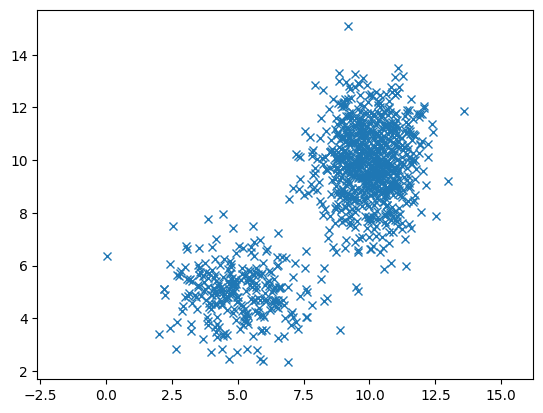

In [20]:
num_samples = 1000
#Let's break down the calculation into clear steps
mn1 = np.array([5,5])
cov1 = np.array([[2,0],
               [0,1]])

mn2 = np.array([10,10])
cov2 = np.array([[1,0],
               [0,2]])

pi = [0.3,0.7]

#Generate samples from the 2 distributions
x1,y1 = np.random.multivariate_normal(mn1,cov1,num_samples).T
x2,y2 = np.random.multivariate_normal(mn2,cov2,num_samples).T


s = np.random.random(num_samples)

x = x2
ix = s<= pi[0]
x[ix] = x1[ix]


y = y2
y[ix] = y1[ix]

# Note this is not a weighted sum!

plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [21]:
# Estimate the parameters of our mixture model.
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 2).fit([list(a) for a in zip(x,y)])
print("Means",gm.means_)
print("---")
print("Covs",gm.covariances_)

Means [[9.99971418 9.93818863]
 [5.04328965 4.97409885]]
---
Covs [[[ 0.97943049  0.05068056]
  [ 0.05068056  2.03942641]]

 [[ 1.88719433 -0.10621274]
  [-0.10621274  1.03357332]]]


In [22]:
# For this data set to be MAR. We will need to have the column ix to be part of the dataset.
# Alteratively we would need to be able to infer ix from the data.

num1 = np.sum(ix)
num2 = num_samples - num1

# select 10 points from cluster 1
rows1 = np.random.permutation(num1)[:10]
aa, = np.where(ix)
x[aa[rows1]] = np.nan


# select 10 points from cluster 2
rows2 = np.random.permutation(num2)[:10]
aa, = np.where(~ix)
x[aa[rows2]] = np.nan


## Missing Not at Random (MNAR)

The probability of a data point being missing is influenced by a mechanism related to the missing data itself, which remains unseen. This represents the most challenging type of missingness, as it is likely to introduce bias into your results unless there is a feasible way to model the missingness mechanism effectively.

For example, consider a thermometer designed for an oven that cannot measure temperatures exceeding 100 degrees Celsius. During typical use, we will be unaware of the actual temperature inside the oven.

### Multiple Imputation

All the methods mentioned above seek to identify the most suitable substitute for any missing data, enabling analysis of a complete dataset. However, this approach is problematic because it implicitly assumes that the imputed data is as accurate as the observed data, which is not necessarily the case. This assumption can lead to inferences that appear overly certain.

An alternative approach is multiple imputation, which aims to account for the uncertainty surrounding imputed data. This is accomplished by creating several datasets, each with different values assigned to the imputed data. Each of these datasets is analysed independently, and the results are then combined for final analysis.

In [23]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X_train = [[1, 1],
           [2, 4],
           [4, 16],
           [np.nan, 25],
           [6, np.nan]]
X_test = [[np.nan, 9],
          [5, np.nan]]
num_datasets = 5

# Generate multiple datasets by changing the seed
for seed in range(num_datasets):
    imp = IterativeImputer(max_iter = 10, random_state = seed, sample_posterior = True)
    imp.fit(X_train)
    print(imp.transform(X_test))

[[ 3.06698885  9.        ]
 [ 5.         22.50616062]]
[[ 1.97181655  9.        ]
 [ 5.         27.32387092]]
[[ 2.52137814  9.        ]
 [ 5.         20.92494775]]
[[ 2.5723911   9.        ]
 [ 5.         20.75056061]]
[[ 2.59713916  9.        ]
 [ 5.         25.16708026]]


### Identifying Missing Data

One final observation to consider is that you might encounter a missing data issue, even when there’s no visible indication of missing values. This can occur if imputation has been applied earlier in the data-processing pipeline. For instance, if a sensor temporarily ceases to function, it may resend the most recent observation, effectively implementing last observation carried forward imputation.

Repeated instances of the same data value, particularly when there is a reasonable expectation of some minor noise, may indicate that the data is unreliable.